## 4.0 CNN Genre Classification with Transfer Learning

This notebook continues with supervised learning using the generated spectorgrams to do genre classification and prediction, but now with transfer learning utilizing pre-trained models.

### Table of Contents
[4.1. Setup](#1.)<br>
[4.1.1 Loading libraries](#1.1)<br>
[4.1.2 Setting data directories](#1.2)<br>
[4.1.3 Defining functions](#1.3)<br>
[4.1.4 Reading in train, validation, and test data sets](#1.4)<br>
[4.1.5 Final preprocessing using Keras model applications](#1.5)<br>

[4.2. Transfer Learning with Single Channel Pre-Trained VGG16](#2.)<br>
[4.2.1 Modified VGG16 with single channel input - 1st attempt](#2.1)<br>
[4.2.2 Modified VGG16 with single channel input - 2nd attempt](#2.2)<br>
[4.2.3 Modified VGG16 with single channel input - further attempts](#2.3)<br>

[4.3. Transfer Learning with Pre-Trained VGG16](#3.)<br>
[4.3.1 VGG16 - 4th attempt](#3.1)<br>
[4.3.2 Further training of VGG16_4 with more subsampled data](#3.2)<br>
[4.3.3 Additional attempt of training of VGG16_4 with more subsampled data](#3.3)<br>

[4.4. Transfer Learning with Pre-Trained NASNet](#4.)<br>
[4.4.1 NASNet - 1st attempt](#4.1)<br>

### 4.1. Setup <a class="anchor" id="1."></a>

#### 4.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [8]:
#!pip show tensorflow
#!pip uninstall "tensorflow"
#!pip install "keras"==1.1.1
#!pip uninstall tensorflow
#!pip install tensorflow==1.4

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
import datetime


import keras
from keras import applications#
from keras import Sequential#
from keras.models import Model, load_model#
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.layers import Input, Dense, Bidirectional, Dropout, Activation #  
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Embedding, Lambda ,concatenate#
from keras.layers import BatchNormalization#

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers

from os.path import isfile

c:\Miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Futu

In [2]:
#import tensorflow.compat.v1 as tf
#tf.compat.v1.disable_eager_execution()

#### 4.1.2 Setting data directories <a class="anchor" id="1.2"></a>

In [2]:
ds_description = '2x10s'
# # Reading in pre-generated seed file
# df_seed = pd.read_csv('./random_seed.csv', delimiter=',')
# Set seed num, if no seed number, set as None
ds_seed_num = 'seed71'

# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("Directory of spectrograms: {}".format(data_dir))

Directory of spectrograms: ./data/spect_subsample_2x10s_np


In [3]:
genre_dict = {0 : 'Hip-Hop',
              1 : 'Pop',
              2 : 'Folk',
              3 : 'Experimental',
              4 : 'Rock',
              5 : 'International',
              6 : 'Electronic',
              7 : 'Instrumental'}

#### 4.1.3 Defining functions <a class="anchor" id="1.3"></a>

In [4]:
def load_data(data_dir, ds_description, ds_seed_num, str_X, str_Y):
    '''
    Loads the .npy data files generated previously from the pre-processing ipynb
    Note: .npy files need to be in the format: train_spect_{ds_description}_np.npy
    
    Inputs
    ------
    data_dir: directory of the .npy files
    ds_description: e.g. '5x10s'  5 subsamples of 10s length
    str_X: str name of the 'X' data, either: 'spect' or 'X'
    str_Y: str name of the 'Y' data, either: 'labels' or 'Y'
    
    Returns
    -------
    6 numpy arrays of:
        train_{str_X}, train_{str_Y}, val_{str_X}, val_{str_Y}, test_{str_X}, test_{str_Y}
    '''
    assert (str_X in ['spect','X']), "Assertion Error, str_X must be either 'spect' or 'X'."
    assert (str_Y in ['labels','Y']), "Assertion Error, str_Y must be either 'labels' or 'Y'."
    
    if ds_seed_num != None:
        ds_description_with_seed = f'{ds_description}_{ds_seed_num}'
    else:
        ds_description_with_seed = f'{ds_description}'
    
    print("Loading .npy data files...")
    # Start timer
    start_time = timeit.default_timer()

    train_str_X = np.load(f'{data_dir}/train_{str_X}_{ds_description_with_seed}_np.npy')
    val_str_X = np.load(f'{data_dir}/val_{str_X}_{ds_description_with_seed}_np.npy')
    test_str_X = np.load(f'{data_dir}/test_{str_X}_{ds_description_with_seed}_np.npy')

    if str_Y == 'labels':
        train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description}_np.npy')
        val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description}_np.npy')
        test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description}_np.npy')
    else:
        train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description_with_seed}_np.npy')
        val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description_with_seed}_np.npy')
        test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description_with_seed}_np.npy')        
    
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("\nLoaded .npy data files, verifying shape of saved data...")
    print(f"Shape of 'train_{str_X}':", train_str_X.shape)
    print(f"Shape of 'train_{str_Y}':", train_str_Y.shape)

    print(f"Shape of 'val_{str_X}':", val_str_X.shape)
    print(f"Shape of 'val_{str_Y}':", val_str_Y.shape)

    print(f"Shape of 'test_{str_X}':", test_str_X.shape)
    print(f"Shape of 'test_{str_Y}':", test_str_Y.shape)
    
    return train_str_X, train_str_Y, val_str_X, val_str_Y, test_str_X, test_str_Y


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

            
def show_summary_stats(history, model_name):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{model_name} model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### 4.1.4 Reading in train, validation, and test data sets <a class="anchor" id="1.4"></a>

In [5]:
# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, ds_seed_num, 'X', 'Y')

Loading .npy data files...

Total processing time (h:mm:ss): 0:06:18

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (12788, 431, 128, 3)
Shape of 'train_Y': (12788, 8)
Shape of 'val_X': (1600, 431, 128, 3)
Shape of 'val_Y': (1600, 8)
Shape of 'test_X': (1600, 431, 128, 3)
Shape of 'test_Y': (1600, 8)


#### 4.1.5 Final preprocessing using Keras model applications <a class="anchor" id="1.5"></a>

In [6]:
# Select one of the relevant preprocess_input based on the model used (eg. VGG16, NASNet, etc...)

from keras.applications.vgg16 import preprocess_input
#from keras.applications.nasnet import preprocess_input

train_X = preprocess_input(train_X)
val_X = preprocess_input(val_X)
test_X = preprocess_input(test_X)

### 4.2. Transfer Learning with Single Channel Pre-Trained VGG16 <a class="anchor" id="2."></a>

#### 4.2.1 Modified VGG16 with single channel input - 1st attempt <a class="anchor" id="2.1"></a>

Utilizing Oxford VGG16 CNN model which is pre-trained on ImageNet data.  However, because VGG16 has its weights trained on 3 channel input (RGB), we would have to extract out the learned weights and for the first layer, we had to do a weighted sum of the 3 channels to a single channel to be able to take in the input of the mel spectrograms.

We re-built the CNN in accordance to the VGG16 architecture and loaded in the pre-trained weights, and tried a variety of combinations for the setting the bottom layers to be untrainable as those had alrady learned low level image recognition features.

https://github.com/RohitSaha/VGG_Imagenet_Weights_GrayScale_Images/blob/master/convert_vgg_grayscale.py

For the first attempt, we set the number of non-trainable layers to be the first 7 layers, which corresponds to the bottom 2 blocks of Conv2D layers, total 4 layers.  We also increased the first dense layer to 256 nodes.

We found that the Adam optimizer was not getting any sort of meaningful convergence in accuracy with the results stagnant at 0.125, and opted to switch to SGD with a small learning rate of 0.001.



In [7]:
#adding for exiting true Azure network
#!pip install "ssl"
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
model_name = 'vgg16_1'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'padding' : 'same',
      'activation' : 'relu',
#      'l2' : 0.01,
      'epochs' : 12,
#      'optimizer' : 'adam',
      'dense1' : 256,
      'dense2' : 16,
      'dropout1' : 0.2
     }
num_classes = len(genre_dict)

train_X1 = train_X
val_X1 = val_X
#train_X1 = np.expand_dims(train_X, axis = -1)
#val_X1 = np.expand_dims(val_X, axis = -1)

tf.keras.backend.clear_session()

# Instantiate the pre-trained VGG16 model without the top dense layer
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
# For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
# RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

# getting weights of block1 conv1.
block1_conv1 = vgg_model.get_layer('block1_conv1').get_weights()
weights, biases = block1_conv1

# :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
# convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
weights = np.transpose(weights, (3, 2, 0, 1))

# Multiple the 3-channels by the RGB weights, and sum along the 3-channel axis
grayscale_weights = np.sum(weights*[0.2989, 0.5870, 0.1140], axis=-1)

# This results in a grayscale_weights shape of [64, 3, 3]
# So we use expand_dims to expand the last axis to convert it to [64, 3, 3, 1]
grayscale_weights = np.expand_dims(grayscale_weights, axis=-1)

# Finally use transpose to change the shape to be [3, 3, 1, 64]
grayscale_weights = np.transpose(grayscale_weights, (1, 2, 3, 0))

# combine :grayscale_weights and :biases
new_block1_conv1 = [grayscale_weights, biases]


# Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

# get weights of all the layers starting from 'block1_conv2'
vgg16_weights = {}
for layer in vgg_model.layers[2:]:
	if "conv" in layer.name:
		vgg16_weights["spect_" + layer.name] = vgg_model.get_layer(layer.name).get_weights()

del vgg_model


# Custom build VGG16
input = Input(shape=(train_X1.shape[1:]), name='spect_input')
print("tomala")
print(input)
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(train_X1.shape[1:]), 
           data_format="channels_last", name='spect_block1_conv1')(input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='spect_block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv3')(x)
x = MaxPooling2D((8, 8), strides=(8, 8), name='spect_block5_pool')(x)

model = Model(inputs=input, outputs=x)

model.get_layer('spect_block1_conv1').set_weights(new_block1_conv1)
for layer in model.layers[2:]:
	if 'conv' in layer.name:
		model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

# model.save('vgg_grayscale_spect.hdf5')

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'])(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'])(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:9]:
    layer.trainable = False
    

# Complie the model

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_1


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(3, 3, 3, 64), dtype=float32) is not an element of this graph.

In [ ]:
show_summary_stats(history, model_name)

In [ ]:
Seems to be overfitting from the start, and the increasing cross-entropy loss 

#### 4.2.2 Modified VGG16 with single channel input - 2nd attempt <a class="anchor" id="2.2"></a>

Due to overfitting from the 1st attempt, we tried to increase the non-trainable layers so that only the last block of 3 Conv2D layers have trainbale parameters.  We also added L2 regularization to the dense layers, decreased the number of nodes in the first dense fully connected layer from 256 to 64 and increased dropout to 50%.

There was still observed overfitting and accuracy was 0.565.

In [16]:
model_name = 'vgg16_2'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'non-trained_layers': 15,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 12,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 16,
      'dropout1' : 0.5
     }
num_classes = len(genre_dict)

train_X1 = train_X
val_X1 = val_X
#train_X1 = np.expand_dims(train_X, axis = -1)
#val_X1 = np.expand_dims(val_X, axis = -1)

keras.backend.clear_session()

# Instantiate the pre-trained VGG16 model without the top dense layer
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
# For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
# RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

# getting weights of block1 conv1.
block1_conv1 = vgg_model.get_layer('block1_conv1').get_weights()
weights, biases = block1_conv1

# :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
# convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
weights = np.transpose(weights, (3, 2, 0, 1))

# Multiple the 3-channels by the RGB weights, and sum along the 3-channel axis
grayscale_weights = np.sum(weights*[0.2989, 0.5870, 0.1140], axis=-1)

# This results in a grayscale_weights shape of [64, 3, 3]
# So we use expand_dims to expand the last axis to convert it to [64, 3, 3, 1]
grayscale_weights = np.expand_dims(grayscale_weights, axis=-1)

# Finally use transpose to change the shape to be [3, 3, 1, 64]
grayscale_weights = np.transpose(grayscale_weights, (1, 2, 3, 0))

# combine :grayscale_weights and :biases
new_block1_conv1 = [grayscale_weights, biases]


# Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

# get weights of all the layers starting from 'block1_conv2'
vgg16_weights = {}
for layer in vgg_model.layers[2:]:
	if "conv" in layer.name:
		vgg16_weights["spect_" + layer.name] = vgg_model.get_layer(layer.name).get_weights()

del vgg_model


# Custom build VGG16
input = Input(shape=(train_X1.shape[1:]), name='spect_input')
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(train_X1.shape[1:]), 
           data_format="channels_last", name='spect_block1_conv1')(input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='spect_block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv3')(x)
x = MaxPooling2D((8, 8), strides=(8, 8), name='spect_block5_pool')(x)

model = Model(inputs=input, outputs=x)

model.get_layer('spect_block1_conv1').set_weights(new_block1_conv1)
for layer in model.layers[2:]:
	if 'conv' in layer.name:
		model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

# model.save('vgg_grayscale_spect.hdf5')

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:hp['non-trained_layers']]:
    layer.trainable = False
    

# Complie the model
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_2


ValueError: Layer weight shape (3, 3, 3, 64) not compatible with provided weight shape (3, 3, 1, 64)

In [ ]:
show_summary_stats(history, model_name)

#### 4.2.3 Modified VGG16 with single channel input - further attempts <a class="anchor" id="2.3"></a>

Reducing batch size from 32 to 16 didn't help.  Extending all non-trainable to 19, which is all convolutional layers, yielded worse results.

Adding BatchNormalization to the input layer with vgg16_2 settings... doesn't work, acc: 0.13

Trying to subtract mean and divide by standard dev for the data sets... no improvement, acc: 0.554

### 4.3 Transfer Learning with Pre-Trained VGG16 <a class="anchor" id="3."></a>


#### 4.3.1 VGG16 - 4th Attempt <a class="anchor" id="3.1"></a>

Reverting to 3-channel RGB inputs with data that is generated in the 2.0 notebook via replicating the single channel to 3 channels.  This also utilizes the specific `preprocess_input` from the Keras VGG16 in [4.1.5](#1.5)

In [8]:
model_name = 'vgg16_4'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'non-trained_layers': 15,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 12,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 32,
      'dropout1' : 0.5
     }
num_classes = len(genre_dict)

keras.backend.clear_session()

# Instantiate the pre-trained VGG16 model without the top dense layer
model = applications.VGG16(weights='imagenet', input_shape=(431,128,3), include_top=False)

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:hp['non-trained_layers']]:
    layer.trainable = False
    

# Compile the model
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_4
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 431, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 431, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 431, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 215, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 215, 64, 128)      73856     
___________________________

c:\Miniconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Instructions for updating:
Use tf.cast instead.
Train on 12788 samples, validate on 1600 samples
Epoch 1/12
12788/12788 [==============================] - 196s 15ms/step - loss: 3.7183 - acc: 0.1211 - val_loss: 3.5607 - val_acc: 0.1250

Epoch 00001: val_acc improved from -inf to 0.12500, saving model to ./models/vgg16_4/weights.best.h5
Epoch 2/12
12788/12788 [==============================] - 188s 15ms/step - loss: 3.4482 - acc: 0.1186 - val_loss: 3.3415 - val_acc: 0.1256

Epoch 00002: val_acc improved from 0.12500 to 0.12562, saving model to ./models/vgg16_4/weights.best.h5
Epoch 3/12
12788/12788 [==============================] - 189s 15ms/step - loss: 3.2464 - acc: 0.1194 - val_loss: 3.1547 - val_acc: 0.1250

Epoch 00003: val_acc did not improve from 0.12562
Epoch 4/12
12788/12788 [==============================] - 188s 15ms/step - loss: 3.0733 - acc: 0.1236 - val_loss: 2.9957 - val_acc: 0.1250

Epoch 00004: val_acc did not improve from 0.12562
Epoch 5/12
12788/12788 [==============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


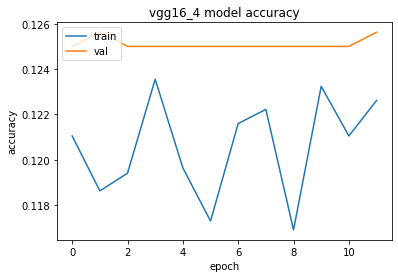

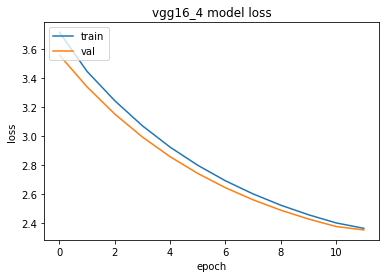

In [9]:
show_summary_stats(history, model_name)

##### There is noticable increase in validation accuracy and decreasing log loss after 6 epochs.<br>
A further 50 epochs were run to see if accuracy can improve past 0.50.

In [10]:
# Load partly trained model
from keras.models import load_model
model = load_model(f'{model_dir}/weights.best.h5')

# Increase the number of epochs for 2nd run
hp['epochs2'] = 50

# Continue training
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs2'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)

Training...
Train on 12788 samples, validate on 1600 samples
Epoch 1/50
12788/12788 [==============================] - 188s 15ms/step - loss: 3.2461 - acc: 0.1187 - val_loss: 3.1548 - val_acc: 0.1250

Epoch 00001: val_acc did not improve from 0.12562
Epoch 2/50
12788/12788 [==============================] - 187s 15ms/step - loss: 3.0735 - acc: 0.1195 - val_loss: 2.9957 - val_acc: 0.1250

Epoch 00002: val_acc did not improve from 0.12562
Epoch 3/50
12788/12788 [==============================] - 188s 15ms/step - loss: 2.9265 - acc: 0.1178 - val_loss: 2.8602 - val_acc: 0.1250

Epoch 00003: val_acc did not improve from 0.12562
Epoch 4/50
12788/12788 [==============================] - 188s 15ms/step - loss: 2.8011 - acc: 0.1225 - val_loss: 2.7449 - val_acc: 0.1250

Epoch 00004: val_acc did not improve from 0.12562
Epoch 5/50
12788/12788 [==============================] - 188s 15ms/step - loss: 2.6945 - acc: 0.1206 - val_loss: 2.6466 - val_acc: 0.1250

Epoch 00005: val_acc did not improve fr

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


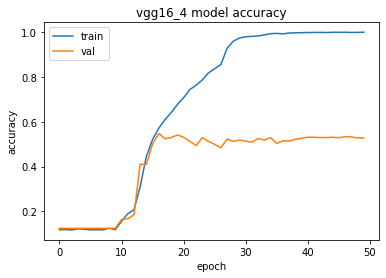

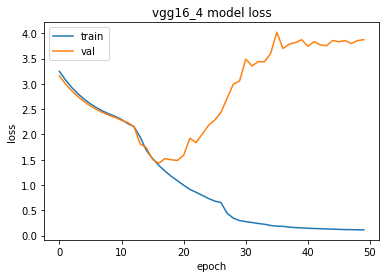

In [11]:
show_summary_stats(history, model_name)

Maximum accuracy of 0.5475 was reached in the 17th epoch of the 2nd training run.

#### 4.3.2 Further training of VGG16_4 with more subsampled data  <a class="anchor" id="3.2"></a>

Using more generated subsampled data to further train the model.  Number of non-trained layers in the VGG16 was also reduced.

In [4]:
keras.backend.clear_session()

# Load previously trained model
from keras.models import load_model
model = load_model(f'./models/vgg16_4/weights.best.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
# Load and preprocess the next set of subsampled data

ds_description = '2x10s'
# Set seed num, if no seed number, set as None
ds_seed_num = 'seed119'
# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("Directory of spectrograms: {}".format(data_dir))

# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, ds_seed_num, 'X', 'Y')

# Select one of the relevant preprocess_input based on the model used (eg. VGG16, NASNet, etc...)
from keras.applications.vgg16 import preprocess_input

train_X = preprocess_input(train_X)
val_X = preprocess_input(val_X)
test_X = preprocess_input(test_X)

Directory of spectrograms: ./data/spect_subsample_2x10s_np
Loading .npy data files...

Total processing time (h:mm:ss): 0:06:56

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (12788, 431, 128, 3)
Shape of 'train_Y': (12788, 8)
Shape of 'val_X': (1600, 431, 128, 3)
Shape of 'val_Y': (1600, 8)
Shape of 'test_X': (1600, 431, 128, 3)
Shape of 'test_Y': (1600, 8)


In [6]:
# Training as vgg16_4-1
model_name = 'vgg16_4-1'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'non-trained_layers': 7,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 25,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 32,
      'dropout1' : 0.5
     }
num_classes = len(genre_dict)

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_4-1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 431, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 431, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 431, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 215, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 215, 64, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 215, 64, 128)      147584    
_________________________________________________________________
block2_pool (M

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


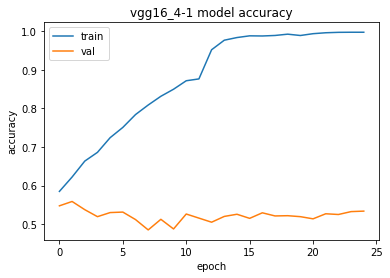

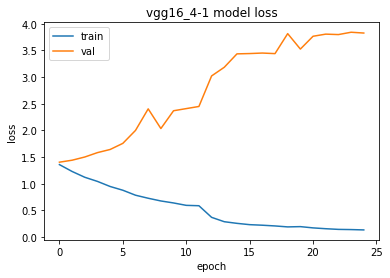

In [7]:
show_summary_stats(history, model_name)

#### 4.3.3 Additional attempt of training of VGG16_4 with more subsampled data  <a class="anchor" id="3.3"></a>

Re-running VGG16_4 with a single run of 25 epochs to validate the results attained, followed by training with second subsampled set.

In [8]:
model_name = 'vgg16_4v2'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'non-trained_layers': 15,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 25,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 32,
      'dropout1' : 0.5
     }
num_classes = len(genre_dict)

keras.backend.clear_session()

# Instantiate the pre-trained VGG16 model without the top dense layer
model = applications.VGG16(weights='imagenet', input_shape=(431,128,3), include_top=False)

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:hp['non-trained_layers']]:
    layer.trainable = False
    

# Complie the model
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_4v2


c:\Miniconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 431, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 431, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 431, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 215, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 215, 64, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 215, 64, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 107, 32, 128)      0         
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


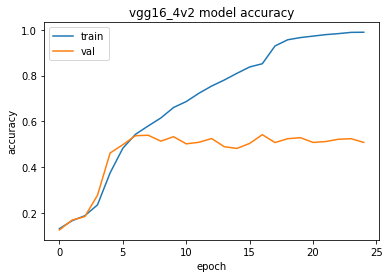

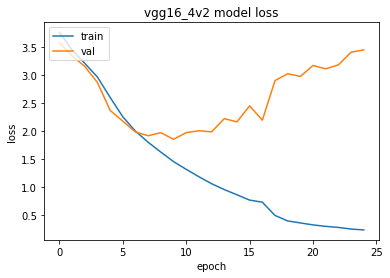

In [9]:
show_summary_stats(history, model_name)

In [10]:
keras.backend.clear_session()

# Load previously trained model
from keras.models import load_model
model = load_model(f'./models/vgg16_4v2/weights.best.h5')

In [11]:
# Load and preprocess the next set of subsampled data

ds_description = '2x10s'
# Set seed num, if no seed number, set as None
ds_seed_num = 'seed119'
# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("Directory of spectrograms: {}".format(data_dir))

# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, ds_seed_num, 'X', 'Y')

# Select one of the relevant preprocess_input based on the model used (eg. VGG16, NASNet, etc...)
from keras.applications.vgg16 import preprocess_input

train_X = preprocess_input(train_X)
val_X = preprocess_input(val_X)
test_X = preprocess_input(test_X)

Directory of spectrograms: ./data/spect_subsample_2x10s_np
Loading .npy data files...

Total processing time (h:mm:ss): 0:04:17

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (12788, 431, 128, 3)
Shape of 'train_Y': (12788, 8)
Shape of 'val_X': (1600, 431, 128, 3)
Shape of 'val_Y': (1600, 8)
Shape of 'test_X': (1600, 431, 128, 3)
Shape of 'test_Y': (1600, 8)


In [12]:
# Training as vgg16_4v2-1
model_name = 'vgg16_4v2-1'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'non-trained_layers': 11,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 25,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 32,
      'dropout1' : 0.5
     }
num_classes = len(genre_dict)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:hp['non-trained_layers']]:
    layer.trainable = False

# Complie the model
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_4v2-1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 431, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 431, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 431, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 215, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 215, 64, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 215, 64, 128)      147584    
_________________________________________________________________
block2_pool 


Epoch 00022: val_acc did not improve from 0.53187
Epoch 23/25
12788/12788 [==============================] - 189s 15ms/step - loss: 0.1065 - acc: 0.9988 - val_loss: 3.6572 - val_acc: 0.5131

Epoch 00023: val_acc did not improve from 0.53187
Epoch 24/25
12788/12788 [==============================] - 189s 15ms/step - loss: 0.1027 - acc: 0.9979 - val_loss: 3.5917 - val_acc: 0.5062

Epoch 00024: val_acc did not improve from 0.53187
Epoch 25/25
12788/12788 [==============================] - 188s 15ms/step - loss: 0.0952 - acc: 0.9990 - val_loss: 3.5742 - val_acc: 0.5200

Epoch 00025: val_acc did not improve from 0.53187


### 4.4. Transfer Learning with Pre-Trained NASNet <a class="anchor" id="4."></a>

#### 4.4.1 NASNet - 1st attempt <a class="anchor" id="4.1"></a>

Reverting to 3-channel RGB inputs with data that is generated in the 2.0 notebook via replicating the single channel to 3 channels.  This also utilizes the specific `preprocess_input` from the Keras NASNet in [4.1.5](#1.5)

In [7]:
model_name = 'nasnet_1'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 8,
      'non-trained_layers': 0,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 12,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 16,
      'dropout1' : 0.7
     }
num_classes = len(genre_dict)

keras.backend.clear_session()

# Instantiate the pre-trained NASNet-Large model without the top dense layer
model = applications.nasnet.NASNetLarge(weights='imagenet', input_shape=(431, 128, 3), include_top=False)

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:hp['non-trained_layers']]:
    layer.trainable = False
    

# Complie the model
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/nasnet_1


ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (331, 331, 3).

In [ ]:
show_summary_stats(history, model_name)